In [1]:
import sys
import os
import skimage.io as io
sys.path.insert(0, '../src')

from importlib import reload
from torchvision import transforms
import torch
import numpy as np

import DataPreperation
import models
# TODO: Implement Evaulation Metrics
#from eval.eval import COCOEvalCap
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
%matplotlib inline

# Evaulation

In [2]:
def test(model_args,
         is_ensemble,
         coco_dataset,
         eval_parallel_batch_size,
         eval_beam_sizes,
         show_predictions,
         array_of_init_seeds,
         model_max_len,
         save_model_path,
         ddp_sync_port):
    """
    @article{hu2022expansionnet,
  title={ExpansionNet v2: Block Static Expansion in fast end to end training for Image Captioning},
  author={Hu, Jia Cheng and Cavicchioli, Roberto and Capotondi, Alessandro},
  journal={arXiv preprint arXiv:2208.06551},
  year={2022}}
    
    """
    print("GPU: " + str(rank) + "] Process " + str(rank) + " working...")

    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = ddp_sync_port
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

    img_size = 384
    if is_end_to_end:
        from models.End_ExpansionNet_v2 import End_ExpansionNet_v2
        model = End_ExpansionNet_v2(swin_img_size=img_size, swin_patch_size=4, swin_in_chans=3,
                                    swin_embed_dim=192, swin_depths=[2, 2, 18, 2], swin_num_heads=[6, 12, 24, 48],
                                    swin_window_size=12, swin_mlp_ratio=4., swin_qkv_bias=True, swin_qk_scale=None,
                                    swin_drop_rate=0.0, swin_attn_drop_rate=0.0, swin_drop_path_rate=0.1,
                                    swin_norm_layer=torch.nn.LayerNorm, swin_ape=False, swin_patch_norm=True,
                                    swin_use_checkpoint=False,
                                    final_swin_dim=1536,

                                    d_model=model_args.model_dim, N_enc=model_args.N_enc,
                                    N_dec=model_args.N_dec, num_heads=8, ff=2048,
                                    num_exp_enc_list=[32, 64, 128, 256, 512],
                                    num_exp_dec=16,
                                    output_word2idx=coco_dataset.caption_word2idx_dict,
                                    output_idx2word=coco_dataset.caption_idx2word_list,
                                    max_seq_len=model_max_len, drop_args=model_args.drop_args,
                                    rank=rank)
    else:
        from models.ExpansionNet_v2 import ExpansionNet_v2
        model = ExpansionNet_v2(d_model=model_args.model_dim, N_enc=model_args.N_enc,
                                N_dec=model_args.N_dec, num_heads=8, ff=2048,
                                num_exp_enc_list=[32, 64, 128, 256, 512],
                                num_exp_dec=16,
                                output_word2idx=coco_dataset.caption_word2idx_dict,
                                output_idx2word=coco_dataset.caption_idx2word_list,
                                max_seq_len=model_max_len, drop_args=model_args.drop_args,
                                img_feature_dim=1536,
                                rank=rank)

    model.to(rank)
    ddp_model = DDP(model, device_ids=[rank])

    data_loader = CocoDataLoader(coco_dataset=coco_dataset,
                                 batch_size=1,
                                 num_procs=world_size,
                                 array_of_init_seeds=array_of_init_seeds,
                                 dataloader_mode='image_wise',
                                 resize_image_size=img_size if is_end_to_end else None,
                                 rank=rank,
                                 verbose=False)

    if not is_ensemble: #Single GPU, this is what we need
        print("Not ensemble")
        map_location = {'cuda:%d' % 0: 'cuda:%d' % rank}
        checkpoint = torch.load(save_model_path, map_location=map_location)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Ensembling Evaluation")
        list_checkpoints = os.listdir(save_model_path)
        checkpoints_list = [save_model_path + elem for elem in list_checkpoints if elem.endswith('.pth')]
        print("Detected checkpoints: " + str(checkpoints_list))

        if len(checkpoints_list) == 0:
            print("No checkpoints found")
            dist.destroy_process_group()
            exit(-1)
        ddp_model = get_ensemble_model(model, checkpoints_list, rank=rank)

    print("Evaluation on Validation Set")
    evaluate_model_on_set(ddp_model, coco_dataset.caption_idx2word_list,
                          coco_dataset.get_sos_token_idx(), coco_dataset.get_eos_token_idx(),
                          coco_dataset.val_num_images,
                          data_loader,
                          CocoDatasetKarpathy.ValidationSet_ID, model_max_len,
                          rank, ddp_sync_port,
                          parallel_batches=eval_parallel_batch_size,
                          use_images_instead_of_features=is_end_to_end,
                          beam_sizes=eval_beam_sizes)

    print("Evaluation on Test Set")
    pred_dict, gts_dict = evaluate_model_on_set(ddp_model, coco_dataset.caption_idx2word_list,
                                                coco_dataset.get_sos_token_idx(), coco_dataset.get_eos_token_idx(),
                                                coco_dataset.test_num_images,
                                                data_loader,
                                                CocoDatasetKarpathy.TestSet_ID, model_max_len,
                                                rank, ddp_sync_port,
                                                parallel_batches=eval_parallel_batch_size,
                                                use_images_instead_of_features=is_end_to_end,
                                                beam_sizes=eval_beam_sizes,
                                                get_predictions=show_predictions)

    if rank == 0 and show_predictions:
        with open("predictions.txt", 'w') as f:
            for i in range(len(pred_dict)):
                prediction = pred_dict[i][0]['caption']
                ground_truth_list = [gts_dict[i][j]['caption'] for j in range(len(gts_dict[i]))]
                f.write(str(i) + '----------------------------------------------------------------------' + '\n')
                f.write('Pred: ' + str(prediction) + '\n')
                f.write('Gt: ' + str(ground_truth_list) + '\n')

    print("[GPU: " + str(rank) + " ] Closing...")
    dist.destroy_process_group()

# Predictions

In [ ]:
refresh(DataPreperation)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = DataPreperation.get_loader(transform=transform_test,    
                         mode='test',              
                         vocab_file='./word_vocab.pkl',
                         vocab_from_file=True,
                         use_word_vocab=True)

[nltk_data] Downloading package punkt to /home/nboren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/nboren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True
/mnt/c/Users/Nickb/PycharmProjects/Image-Captioning/notebooks
./word_vocab.pkl
Word Vocabulary successfully loaded from ./word_vocab.pkl file


In [36]:
# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-2.pkl' 
decoder_file = 'decoder-2.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = models.EncoderCNN(embed_size)
encoder.eval()
decoder = models.DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('../models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('../models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(9438, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9438, bias=True)
)

In [37]:
def clean_sentence(output):
    list_string = []
    
    for idx in output:
        list_string.append(data_loader.dataset.vocab.idx2word[idx])
    
    list_string = list_string[1:-1] # Discard  and  words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

In [41]:
def get_prediction(encoder_type, decoder_type):
    orig_image, image = next(iter(data_loader))

    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder_type(image).unsqueeze(1)
    output = decoder_type.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

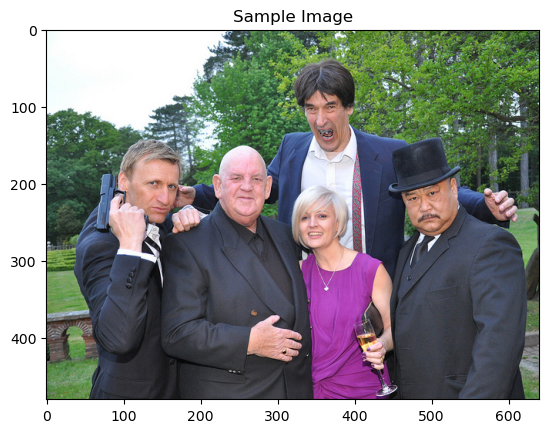

A group of people standing around each other .


In [60]:
get_prediction(encoder, decoder)

In [ ]:
def clean_sentence(output):
    list_string = []
    
    print(output)
    for idx in output:
        list_string.append(data_loader.dataset.vocab.idx2char[idx])
    
    list_string = list_string[1:-1] # Discard  and  words
    print(list_string)
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = DataPreperation.get_loader(transform=transform_test,    
                         mode='test',
                         vocab_file='./char_vocab.pkl',
                         vocab_from_file=True,
                         use_word_vocab=False)

In [ ]:
encoder_file = 'char_encoder-1.pkl' 
decoder_file = 'char_decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder_char = models.EncoderCNN(embed_size).to(device)
encoder.eval()
decoder_char = models.DecoderRNN(embed_size, hidden_size, vocab_size).to(device)
decoder.eval()

# Load the trained weights.
encoder_char.load_state_dict(torch.load(os.path.join('../models', encoder_file)))
decoder_char.load_state_dict(torch.load(os.path.join('../models', decoder_file)))

# Move models to GPU if CUDA is available.
#encoder_char.to(device)
#decoder_char.to(device)

In [ ]:
get_prediction(encoder_char, decoder_char)